In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')

# CONFIGURATIE
HOUSES_CONFIG = [
    {
        'name': 'House1', 
        'file': 'CLEAN_House1.csv',
        'start_date': '2014-04-01',
        'end_date': '2015-05-01'
    },
    {
        'name': 'House2', 
        'file': 'CLEAN_House2.csv',
        'start_date': '2013-11-01', # Folosim același interval stabil pentru ambele
        'end_date': '2014-03-01'
    }
]

WINDOW_SIZE = 48 # ore
TRAIN_SPLIT = 0.8
SAMPLE_SIZE = 50000 # Pentru optimizarea KMeans



 ANALIZĂ FIȘIER: CLEAN_House1.csv
Interval total: 2013-10-09 13:00:00 -> 2015-07-10 11:00:00
Total ore în calendar: 15335
Ore lipsă efectiv: 1815 (11.84% din timp)


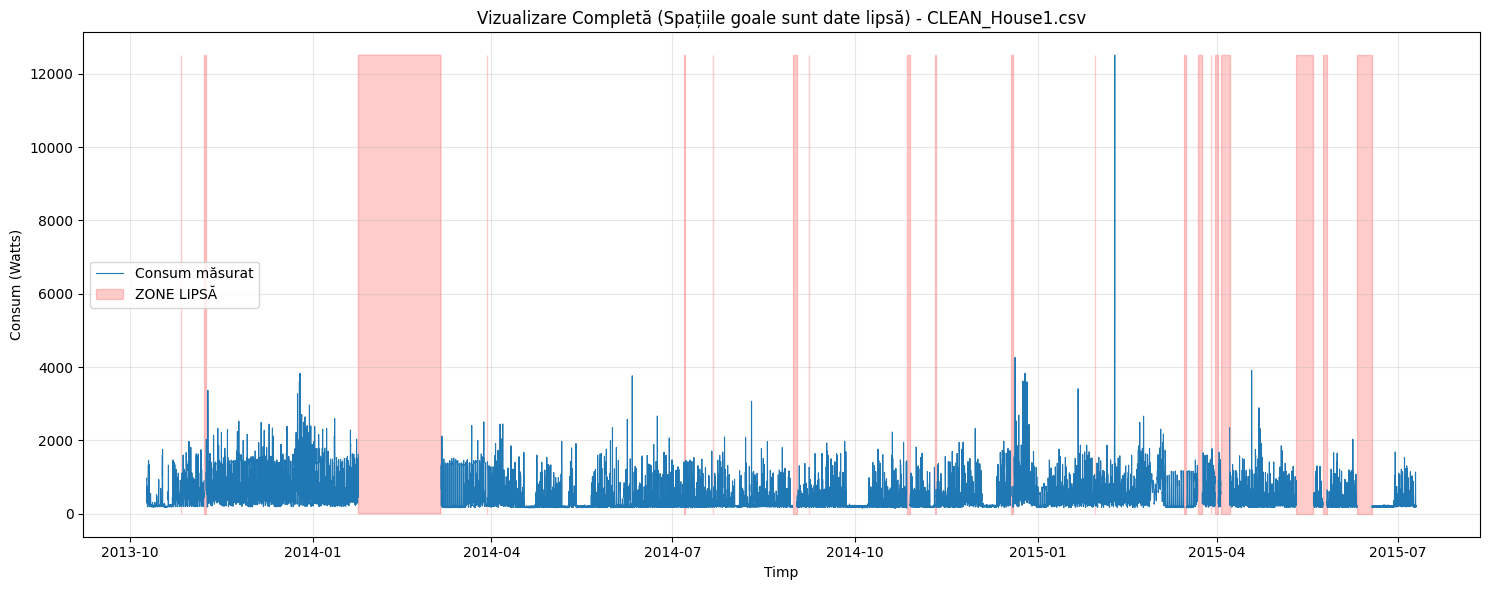


--- Top 3 Cele mai mari întreruperi detectate ---
GAP DETECTAT: 998 ore lipsă
   De la: 2014-01-24 02:00:00
   Până la: 2014-03-06 15:00:00
------------------------------
GAP DETECTAT: 207 ore lipsă
   De la: 2015-05-11 00:00:00
   Până la: 2015-05-19 14:00:00
------------------------------
GAP DETECTAT: 179 ore lipsă
   De la: 2015-06-10 14:00:00
   Până la: 2015-06-18 00:00:00
------------------------------

 ANALIZĂ FIȘIER: CLEAN_House2.csv
Interval total: 2013-09-17 22:00:00 -> 2015-05-28 08:00:00
Total ore în calendar: 14819
Ore lipsă efectiv: 3465 (23.38% din timp)


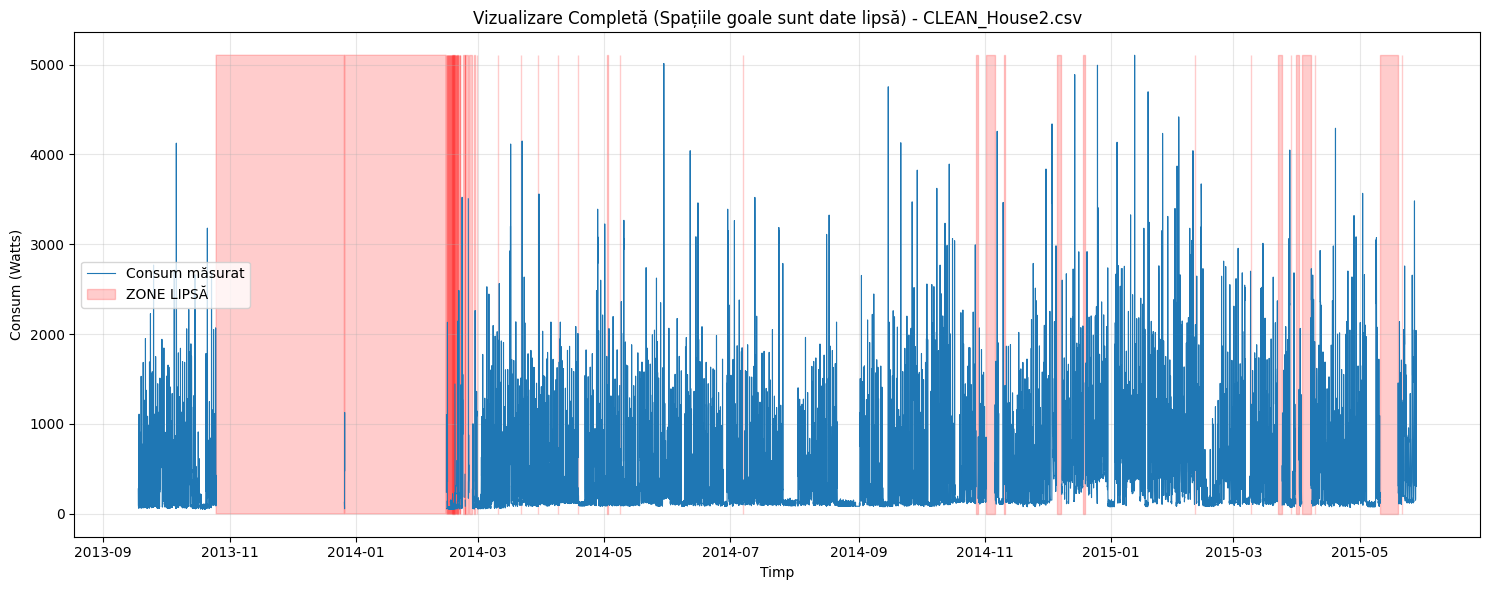


--- Top 3 Cele mai mari întreruperi detectate ---
GAP DETECTAT: 1487 ore lipsă
   De la: 2013-10-25 13:00:00
   Până la: 2013-12-26 11:00:00
------------------------------
GAP DETECTAT: 1175 ore lipsă
   De la: 2013-12-26 17:00:00
   Până la: 2014-02-13 15:00:00
------------------------------
GAP DETECTAT: 207 ore lipsă
   De la: 2015-05-11 00:00:00
   Până la: 2015-05-19 14:00:00
------------------------------


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- DEFINIREA FUNCȚIEI ---
def visualize_all_gaps(filename):
    print(f"\n{'='*50}")
    print(f" ANALIZĂ FIȘIER: {filename}")
    print(f"{'='*50}")
    
    try:
        # 1. Încărcare Date
        df = pd.read_csv(filename)
        df['dt'] = pd.to_datetime(df['Time'])
        df.set_index('dt', inplace=True)
        
        # Selectăm doar coloana de interes
        df = df[['Aggregate']].copy()
        df['Aggregate'] = pd.to_numeric(df['Aggregate'], errors='coerce')

        # 2. RESAMPLING FĂRĂ FILLNA
        df_full = df.resample('1h').mean()
        
        # 3. Calcul Statistici
        total_ore = len(df_full)
        ore_lipsa = df_full['Aggregate'].isna().sum()
        print(f"Interval total: {df_full.index.min()} -> {df_full.index.max()}")
        print(f"Total ore în calendar: {total_ore}")
        print(f"Ore lipsă efectiv: {ore_lipsa} ({ore_lipsa/total_ore:.2%} din timp)")

        # 4. VIZUALIZARE GRAFICA
        plt.figure(figsize=(15, 6))
        
        # Plotam seria
        plt.plot(df_full.index, df_full['Aggregate'], label='Consum măsurat', linewidth=0.8)
        
        plt.title(f"Vizualizare Completă (Spațiile goale sunt date lipsă) - {filename}")
        plt.ylabel("Consum (Watts)")
        plt.xlabel("Timp")
        plt.grid(True, alpha=0.3)
        
        # Opțional: Coloram fundalul zonelor lipsa cu rosu pal
        is_missing = df_full['Aggregate'].isna()
        plt.fill_between(df_full.index, 0, df_full['Aggregate'].max(), 
                         where=is_missing, color='red', alpha=0.2, label='ZONE LIPSĂ')
        
        plt.legend()
        plt.tight_layout()
        plt.show()

        # 5. DETECTARE AUTOMATA A CELEI MAI MARE GAP
        print("\n--- Top 3 Cele mai mari întreruperi detectate ---")
        
        mask = df_full['Aggregate'].isna()
        grp = (mask != mask.shift()).cumsum()
        grp = grp[mask] # Pastram doar grupurile care sunt NaN
        
        if not grp.empty:
            gap_sizes = grp.value_counts()
            top_gaps = gap_sizes.head(3)
            
            for group_id, size in top_gaps.items():
                indices = grp[grp == group_id].index
                start_gap = indices.min()
                end_gap = indices.max()
                
                print(f"GAP DETECTAT: {size} ore lipsă")
                print(f"   De la: {start_gap}")
                print(f"   Până la: {end_gap}")
                print("-" * 30)
        else:
            print("Nu s-au găsit date lipsă!")
            
    except Exception as e:
        print(f"[EROARE] Nu s-a putut procesa {filename}: {e}")

# --- APELARE PENTRU CELE DOUĂ CASE ---
fisiere_case = ['CLEAN_House1.csv', 'CLEAN_House2.csv']

for fisier in fisiere_case:
    visualize_all_gaps(fisier)

In [7]:
# --- FUNCTIE 1: INCARCARE SI FEATURES ---
def process_dataframe(filename):
    print(f"\n[INFO] Procesare fisier: {filename}...")
    df = pd.read_csv(filename)
    df['dt'] = pd.to_datetime(df['Time'])
    df.set_index('dt', inplace=True)
    df = df[['Aggregate']]
    df['Aggregate'] = pd.to_numeric(df['Aggregate'], errors='coerce')

    START_DATE = '2014-04-01'
    END_DATE   = '2015-05-01'
    df_cut = df[(df.index >= START_DATE) & (df.index < END_DATE)].copy()
    # Resampling
    df_1H = df_cut.resample('1H').mean()

    #  Verificare rapida 
    print(f"NaN-uri rămase: {df_1H['Aggregate'].isna().sum()} din {len(df_1H)} ({df_1H['Aggregate'].isna().mean() * 100:.4f}%)") 
    # 3. Umplem micile gauri care au apărut la resampling (dacă există)
    df_1H['Aggregate'] = df_1H['Aggregate'].interpolate(limit=2).fillna(method='ffill')

    
    # Features
    df_1H['Month'] = df_1H.index.month
    df_1H['Month_Scaled'] = (df_1H['Month'] - 1) / 11.0
    df_1H['Hour'] = df_1H.index.hour
    df_1H['DayOfWeek'] = df_1H.index.dayofweek
    df_1H['Hour_Sin'] = np.sin(2 * np.pi * df_1H['Hour'] / 24.0)
    df_1H['Hour_Cos'] = np.cos(2 * np.pi * df_1H['Hour'] / 24.0)
    df_1H['IsWeekend'] = df_1H['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    df_1H['DayOfWeek_Scaled'] = df_1H['DayOfWeek'] / 6.0

    print(df_1H)
    
    return df_1H

# --- FUNCTIE 2: CLUSTERING ---
def apply_clustering(df, train_len):
    print("[INFO] Optimizare si aplicare KMeans (fit pe train, predict pe test)...")

    # Split pe df (doar pentru antrenarea KMeans fara leakage)
    df_train = df.iloc[:train_len].copy()
    df_test  = df.iloc[train_len:].copy()

    # Esantion doar din train pentru alegerea lui k
    data_sample = df_train[['Aggregate']].sample(
        n=min(SAMPLE_SIZE, len(df_train)),
        random_state=42
    ).values

    range_n_clusters = [2, 3, 4, 5]
    scores = []
    for k in range_n_clusters:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(data_sample)
        scores.append(silhouette_score(data_sample, labels))

    best_k = range_n_clusters[np.argmax(scores)]
    print(f" -> Cel mai bun k detectat (train): {best_k}")

    # Fit pe train, predict pe test
    kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    df_train['Cluster'] = kmeans_final.fit_predict(df_train[['Aggregate']].values)
    df_test['Cluster']  = kmeans_final.predict(df_test[['Aggregate']].values)

    # Ordonare pentru cazul k=2 (0 = low, 1 = high)
    centers = kmeans_final.cluster_centers_.flatten()
    if len(centers) == 2 and centers[0] > centers[1]:
        df_train['Cluster'] = 1 - df_train['Cluster']
        df_test['Cluster']  = 1 - df_test['Cluster']

    # Recombinare, cu aceleasi randuri ca df initial
    df_out = pd.concat([df_train, df_test], axis=0)
    return df_out, kmeans_final


# --- FUNCTIE 3: SECVENTE ---
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


def prepare_and_save(df, kmeans_model, house_name):
    print(f"[INFO] Generare secvente pentru {house_name}...")
    
    # ============================================================
    # 1. Selectarea feature-urilor brute (fara scalare initiala)
    # ============================================================
    features_cols_raw = [
        'Aggregate',
        'Hour_Sin',
        'Hour_Cos',
        'DayOfWeek_Scaled',
        'IsWeekend',
        'Month_Scaled',
        'Cluster'
    ]

    dataset_raw = df[features_cols_raw].values

    # ============================================================
    # 2. Split temporal train / test
    # ============================================================
    train_len = int(len(dataset_raw) * TRAIN_SPLIT)

    train_raw = dataset_raw[:train_len]
    test_raw  = dataset_raw[train_len:]

    # ============================================================
    # 3. Scalare DOAR pe setul de antrenare (evitare data leakage)
    # ============================================================
    scaler = RobustScaler()

    # Coloana 0 = Aggregate
    train_agg_scaled = scaler.fit_transform(train_raw[:, [0]])
    test_agg_scaled  = scaler.transform(test_raw[:, [0]])

    # ============================================================
    # 4. Reconstruirea dataset-ului final scalat
    #    Aggregate_Scaled + celelalte feature-uri nemodificate
    # ============================================================
    train_data = np.concatenate([train_agg_scaled, train_raw[:, 1:]], axis=1)
    test_data_values = np.concatenate([test_agg_scaled, test_raw[:, 1:]], axis=1)

    # ============================================================
    # 5. Crearea secventelor pentru antrenare
    # ============================================================
    X_train, y_train = create_sequences(train_data, WINDOW_SIZE)

    # ============================================================
    # 6. Crearea secventelor pentru test
    #    Se concateneaza ultimele WINDOW_SIZE valori din train
    #    pentru a pastra contextul temporal
    # ============================================================
    test_inputs = np.concatenate((train_data[-WINDOW_SIZE:], test_data_values))
    X_test, y_test = create_sequences(test_inputs, WINDOW_SIZE)

    # ============================================================
    # 7. Salvare fisier procesat
    # ============================================================
    save_filename = f'processed_data_{house_name}.pkl'

    data_package = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'scaler': scaler,
        'kmeans': kmeans_model,
        'test_data': df.iloc[train_len:],   # datele brute din test (pentru analiza)
        'df_1H': df,                      # dataframe-ul complet procesat
        'WINDOW_SIZE': WINDOW_SIZE,
        'train_size': train_len
    }
        
    with open(save_filename, 'wb') as f:
            pickle.dump(data_package, f)
            
    print(
        f"[SUCCESS] Salvat: {save_filename} | "
        f"Train: samples={X_train.shape[0]}, "
        f"timesteps={X_train.shape[1]}, "
        f"features={X_train.shape[2]} | "
        f"Test: samples={X_test.shape[0]}, "
        f"timesteps={X_test.shape[1]}, "
        f"features={X_test.shape[2]}"
    )


In [8]:
# Iteram prin fiecare casa
for house in HOUSES_CONFIG:
    print(f"\n{'='*40}")
    print(f"START PROCESARE: {house['name']}")
    print(f"{'='*40}")
    
    try:
        # 1. Incarcare si Features
        df = process_dataframe(house['file'])
        
        # 2. Clustering
        train_len = int(len(df) * TRAIN_SPLIT)
        df, kmeans_model = apply_clustering(df, train_len)
        
        # 3. Salvare (Sequences)
        prepare_and_save(df, kmeans_model, house['name'])
        
    except Exception as e:
        print(f"[EROARE] Problema la {house['name']}: {e}")

print("\n" + "="*50)
print("--- TOATE CASELE AU FOST PROCESATE ---")
print("GATA! Fisierele .pkl sunt generate.")
print("Poti trece acum la urmatorul notebook: '02_Models_Training.ipynb'")
print("="*50)


START PROCESARE: House1

[INFO] Procesare fisier: CLEAN_House1.csv...
NaN-uri rămase: 356 din 9480 (3.7553%)
                      Aggregate  Month  Month_Scaled  Hour  DayOfWeek  \
dt                                                                      
2014-04-01 00:00:00  848.060000      4      0.272727     0          1   
2014-04-01 01:00:00  961.215000      4      0.272727     1          1   
2014-04-01 02:00:00  873.575000      4      0.272727     2          1   
2014-04-01 03:00:00  893.386667      4      0.272727     3          1   
2014-04-01 04:00:00  852.123103      4      0.272727     4          1   
...                         ...    ...           ...   ...        ...   
2015-04-30 19:00:00  960.025974      4      0.272727    19          3   
2015-04-30 20:00:00  354.001859      4      0.272727    20          3   
2015-04-30 21:00:00  438.442379      4      0.272727    21          3   
2015-04-30 22:00:00  582.333333      4      0.272727    22          3   
2015-04-30 23: